![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting TIFF  data 

- `2048*2048*1447*float32` Each timestep is **22 GiB**
- 900 timesteps **20TB**

In [1]:
import time
import os
import numpy as np
import argparse
import glob
import os
import numpy as np

from matplotlib import pyplot as plt
from skimage import io

# ///////////////////////////////////////////////////////////////
def ShowImage(img, histogram=True):
	print("dtype",img.dtype,"shape",img.shape,"m",np.min(img),"M",np.max(img))
	fig = plt.figure()
	fig.set_size_inches(18.5, 10.5)

	ax = fig.add_subplot(1, 2, 1) # nrows, ncols, index
	imgplot = plt.imshow(img)

	plt.colorbar(orientation='horizontal')
	
	if histogram:
		ax = fig.add_subplot(1, 2, 2)
		histogram, bin_edges = np.histogram(img, bins=256, range=(np.min(img), np.max(img)))
		plt.title("Histogram")
		plt.xlabel("value")
		plt.ylabel("pixel count")
		plt.xlim([np.min(img), np.max(img)])
		plt.plot(bin_edges[0:-1], histogram)


W 2048 H 2048 D 1447 dtype uint16
dtype uint16 shape (2048, 2048) m 0 M 70


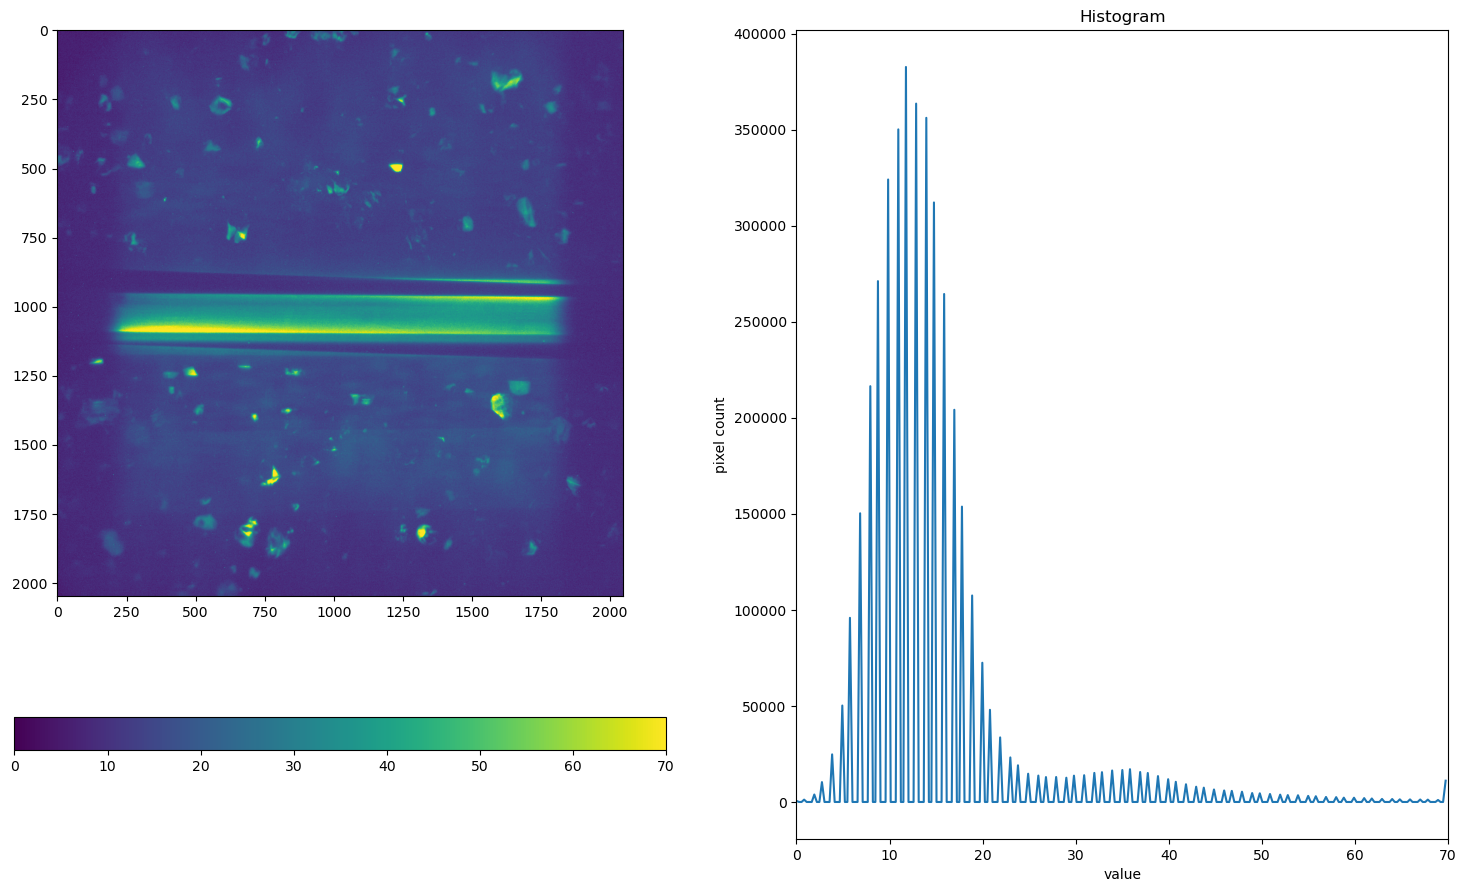

In [2]:
# example: show a tif image

filenames=list(sorted(glob.glob("/nfs/chess/nsdf01/vpascucci/allison-1110-3/mg4al-sht/11/nf/*.tif")))

D=len(filenames)
img = io.imread(filenames[D//2])
H,W=img.shape
print("W",W,"H",H,"D",D,"dtype",img.dtype)
ShowImage(np.clip(img, 0, 70))

# Import OpenVisus

In [3]:
import OpenVisus as ov
import logging
os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")
# ov.SetupLogger(logger, output_stdout=True) 
print("OpenVisus imported")

OpenVisus imported


# Create the IDX file

In [4]:
idx_filename="/mnt/data1/nsdf/tmp/allison-1110-3/mg4al-sht/11/nf/visus.idx"

# ************ dangerous (make sure you are in a tmp directory) ************ 
import os,sys,shutil
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

fields=[ov.Field("data",str(img.dtype),"row_major")]
db=ov.CreateIdx(
	url=idx_filename,
	dims=[W,H,D],
	fields=fields,
	compression="raw")

print(type(db))
print(db.getDatasetBody().toString())

<class 'OpenVisus.dataset.PyDataset'>
<dataset url="/mnt/data1/nsdf/tmp/allison-1110-3/mg4al-sht/11/nf/visus.idx" cache_dir="" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V012012012012012012012012012012012" />
		<box value="0 2048 0 2048 0 1447" />
		<bitsperblock value="16" />
		<blocksperfile value="1024" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%02x/%04x.bin" />
		<missing_blocks value="False" />
		<arco value="0" />
		<time_template value="" />
		<field name="data" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="uint16" />
		<timestep when="0" />
	</idxfile>
</dataset>


# Write data to OpenVisus

In [5]:
t1 = time.time()

def generateSlices():
    for Z in range(D): 
        # print(f"Writing {Z}/{D}...")
        yield io.imread(filenames[Z])

db.writeSlabs(generateSlices())
print(f"db.write done in {time.time() - t1} seconds")

db.write done in 25.20412564277649 seconds


# Show OpenVisus data

(2048, 2048) uint16
dtype uint16 shape (2048, 2048) m 0 M 70


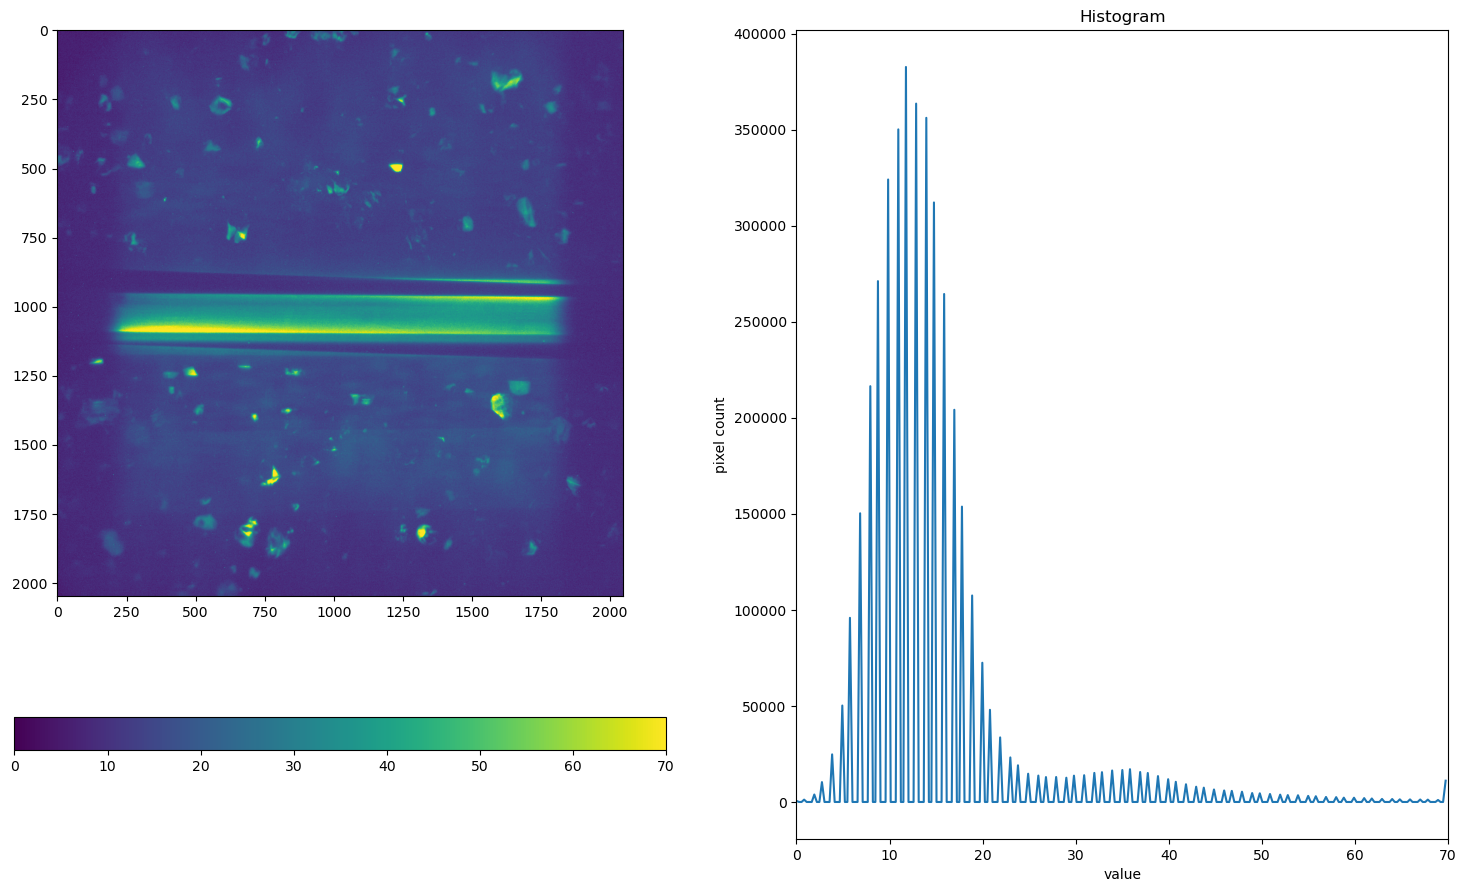

In [6]:
Z=D//2
slice=db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=1, quality=0)[0,:,:]
print(slice.shape,slice.dtype)
ShowImage(np.clip(slice, 0, 70))


# Get from OpenVisus server

You need to 

- add the dataset to the `/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config`
- launch the Open Visus server
```

Get credentials to access the OpenVisus server:

dtype uint16 shape (2048, 2048) m 0 M 70


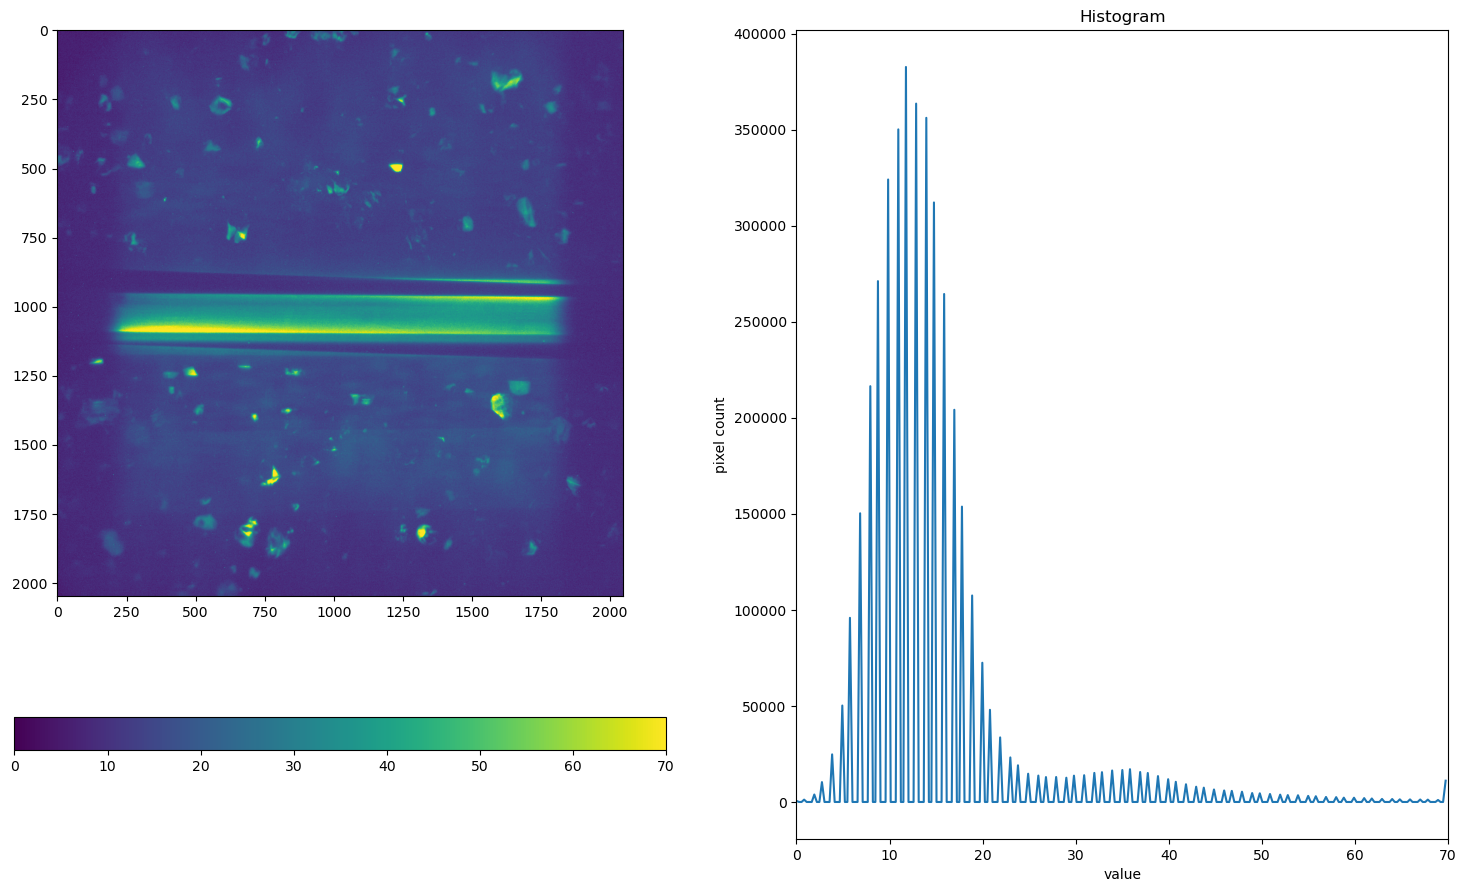

In [7]:
username,password=None,None
with open("/nfs/chess/nsdf01/openvisus/.mod_visus.identity.sh","rt") as file:
    for line in file.read().split():
        if "MODVISUS_USERNAME=" in line:
            username=line[line.index("MODVISUS_USERNAME=")+len("MODVISUS_USERNAME="):].strip()
            continue
        if "MODVISUS_PASSWORD=" in line:
            password=line[line.index("MODVISUS_PASSWORD=")+len("MODVISUS_PASSWORD="):].strip()
            continue

db=ov.LoadDataset(f"https://nsdf01.classe.cornell.edu/mod_visus?dataset=allison-1110-3-mg4al-sht-11-nf&~auth_username={username}&~auth_password={password}")
slice=db.read(x=[0,W],y=[0,H],z=[Z,Z+1], num_refinements=1, quality=0)[0,:,:]
ShowImage(np.clip(slice, 0, 70))